![DBC](Images/DBC.png)

# Scholar Metrics Scraper: ScholarScraper notebook

**Introduction**

This notebook automates the process of retrieving bibliometric data from Google Scholar for a list of authors. It utilizes [scholarly](https://pypi.org/project/scholarly/), a Python module that allows users to retrieve bibliometrics from [Google Scholar](https://scholar.google.ca/). It also creates a citations/year bar chart and a collaborations heatmap. This notebook should be run before the ScholarCollabs and GroupedCollabs notebooks.

This project currently works with scholarly 1.4.5

**Installation and Setup**

1. Set-up Jupyter. If your institution has access, you can use [Syzygy](https://syzygy.ca/) to run in the Cloud, or install on your computer following [these instructions](https://jupyter.org/install).
2. Clone the project.
    - Open Terminal (in Syzygy, click the "+" button to open a new launcher and click "Terminal"
    - Type  "git clone https://github.com/ubcbraincircuits/scholar_metrics_scraper" and press enter
    - The project should now be cloned in your directory. 
    - Alternatively, you can download the project as a ZIP file from https://github.com/ubcbraincircuits/scholar_metrics_scraper(click Code, then Download ZIP)
3. [Install scholarly](https://pypi.org/project/scholarly/)
    - In the terminal (from above) type "pip install scholarly" or "pip install --user scholarly" and press enter
4. Obtain a CSV file with the list of author names in a single column with no column header. Ideally, all author names should match their names in Google Scholar. Upload this file to Syzygy or move it to the project folder on your computer. This file should be in the same directory as this notebook file (ScholarScraper.ipynb). 
5. Modify the names of the input/output files below (in step 2). The input file name must match the CSV file name. 
6. Modify the "affiliations" variable as a list of institution names which the researchers are affiliated with. Include both abbreviated and long form.  
7. Run all cells (click shift+enter to run a cell or the play button above). 
8. Open the ouput CSV file in the same directory as this notebook file. Check the last column of this file for warnings. If needed, modify the author names in the input CSV file if the wrong author profile was scraped, or no profile was found, and re-run.


**Steps**

1. Install and load libraries and packages.


In [2]:
# from scholarly import ProxyGenerator
# pg = ProxyGenerator()

In [15]:

#If you receive an error running this cell for the first time, try running it agian. 

from scholarly import scholarly
import csv
import warnings
import ast
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm as CM


2. Modify the names of the input and output files. The name of the input file should match the name of the author list CSV file. If you followed the setup instructions, the CSV file should now be in the same directory as this notebook file. The output file does not have to exist yet (it will be created). 

In [53]:
# !!! Modify this to match the name of your author list CSV file. 
author_list_csv = 'authorlist comparisons/inputs/authorlist_new.csv'
output_data_csv = 'gs_SMS_adjustedauthorlist.csv'

bargraph_output = "gs_bargraph.pdf"
figure_output = "gs_heatmap.pdf"

3. Load in the author names from the CSV file. 

In [54]:
authorlist_df = pd.read_csv(author_list_csv)

# author_names = []
# with open(author_list_csv, encoding ="utf-8-sig") as csv_file:
#     csv_reader = csv.reader(csv_file, delimiter =',')
#     for row in csv_reader:
#         if (len(row) == 1):
#             author_names.append(row[0])
            

In [55]:
print(authorlist_df.head())
print(pd.isna(authorlist_df.iloc[0, 1]))

                   Name GSID
0         Tim H. Murphy  NaN
1         Annie Ciernia  NaN
2        Brian MacVicar  NaN
3  Fidel Vila-Rodriguez  NaN
4         Shernaz Bamji  NaN
True


4. Modify the affiliations list with institutions which the researchers are affiliated with. 

In [56]:
affiliations = ['University of British Columbia', 'UBC', 'Djavad Mowafaghian', 'Simon Fraser University', 'University of Victoria', 'University of Washington']

5. Scrape data for each author. This will take several minutes. 

In [59]:
# This will contain all the data for each author which will be exported as a table. It will be a list of dictionaries. 
rows = []
# This will contain a list of dictionaries for each author. The dictionaries will be made up of years as keys and citation numbers as vals
cites_per_year = []
# This dictionary will contain publication titles as keys and author names as values
pub_authors = {}


for idx, athr in authorlist_df.iterrows():
    used_athr_ID = False
    pubs = []
    try :
        if pd.isna(athr["GSID"]):
            search_query = scholarly.search_author(athr['Name'])
            author = next(search_query) 
        else:
            author = scholarly.search_author_id(athr['GSID'])
            used_athr_ID = True
            

    except (RuntimeError,TypeError,StopIteration):
        row = {'Name': athr, 'Warning': 'no information found'}
    else:
        data_dict = scholarly.fill(author, sections=['basics', 'indices', 'publications', 'counts'])
        
        # Get publications titles 
        for pub in data_dict['publications']:
            pubs.append(pub['bib']['title'])
            # Add to dictionary with title as key and author as value if the author has not been already seen
            if (pub['bib']['title'] not in pub_authors.keys()) or (data_dict['name'] not in pub_authors[pub['bib']['title']]): 
                pub_authors.setdefault(pub['bib']['title'],[]).append(data_dict['name'])
        
        # Get citations per year and put in dictionary
        cites_per_year_dict = data_dict['cites_per_year']
        # Add name to dictionary 
        cites_per_year_dict['name'] = data_dict['name']
        cites_per_year.append(cites_per_year_dict)
        
        # Create row (dictionary) for output data table
        row = {'Name': athr['Name'],
               'GS Profile Name': data_dict['name'], 
               'Scholar ID': data_dict['scholar_id'], 
               'Cited by': data_dict.get('citedby', ''), 
               'Cited by 5 years': data_dict.get('citedby5y',''), 
               'h-index': data_dict.get('hindex',''), 
               'h-index 5 years': data_dict.get('hindex5y',''), 
               'i10-index': data_dict.get('i10index',''),
               'i10-index 5 years': data_dict.get('i10index5y',''), 
               '"Publications"': pubs, 
               'Document Count': len(pubs), 
               'Affiliation': data_dict['affiliation']}
        
        # Create list of authors who do not have the specified affiliation

        if used_athr_ID == False and not any(a in data_dict['affiliation'] for a in affiliations):
            row['Warning'] = "Affiliation does not match!"
            
    finally:    
        rows.append(row)
        used_athr_ID = False
        
                

Tim H. Murphy
Annie Ciernia
Brian MacVicar
Fidel Vila-Rodriguez
Shernaz Bamji
Lara Boyd
Paul Pavlidis
Martin McKeown
A Jon Stoessl
Peter Cripton
Jason Snyder
Anthony Phillips
Catharine Winstanley
Yu Tian Wang
Jeremy Seamans
Ian Mackenzie
Lynn Raymond
Kurt Haas
Mark Cembrowski
Fabio Rossi
Jane Roskams
Catharine Rankin
Michael Gordon
Leonid Sigal
Peyman Servati
Silke Cresswell
Helge Rhodin
Manu Madhav
Brian D. Fisher
Leigh Anne Swayne
Craig E. Brown
Adrienne Fairhall
Eric Shea-Brown
Emily Sylwestrak
Andy Shih
Todd Woodward


5.a) Validate author names. Add GSIDs to GSID row in author list if manual lookup is required. If author list required any changes, rerun steps 2-5.

In [68]:

keys = [
    'Name',
    'GS Profile Name', 
    'Scholar ID', 
    'Document Count', 
    'Cited by', 
    'Cited by 5 years', 
    'h-index', 
    'h-index 5 years',  
    'i10-index', 
    'i10-index 5 years', 
    'Affiliation', 
    'Warning',
    ]

out_rows = [{key: rows[row_num][key] for key in keys if key in rows[row_num].keys()} for row_num in range(len(rows))]

with open(output_data_csv, mode='w', encoding ="utf-8") as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    dict_writer = csv.DictWriter(csv_file, keys, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    dict_writer.writeheader()
    dict_writer.writerows(rows)

ValueError: dict contains fields not in fieldnames: '"Publications"'

5.b) Get an output of publications with co-authors. Manually review for inconsistent/misattributed material and delete or adjust the rows in the CSV file.

In [8]:
coauthored_pubs = [
    title
    for title, authors in pub_authors.items() 
    if len(authors) > 1]

coauthored_authors = [
    authors
    for title, authors in pub_authors.items() 
    if len(authors) > 1]

coauthored_df = pd.DataFrame({"Title": coauthored_pubs, "Coauthors": coauthored_authors})

In [18]:
coauthored_df.to_csv("ss_coauthored_pubs.csv",index=False)
#differences between ss_coauthored_pubs and ss_coauthored_pubs copy:

##### removed:
##### malformed text parsing #####
# A Journal Devoted to Funconal Neuroanatomy and Neuroimaging,"['Sophia Frangou', 'Anthony Randal McIntosh']"
# A Journal Devoted to Funcঞonal Neuroanatomy and Neuroimaging,"['Sophia Frangou', 'Anthony Randal McIntosh']"
# ÔØ Å ÒÙ× Ö ÔØ,"['Paul Pavlidis', 'Sophia Frangou', 'Vesna Sossi']" (GS data attempting to read "Accepted Manuscript" in a specific font from the PDF, leading to collection of strange symbols.)
# University of British Columbia,"['Martin J. McKeown', 'Brian D. Fisher']" (Martin J McKeown: seems to be a GS misattribution issue, where affiliation is interpreted as a title from citations; Brian D. Fisher: actual article titled "University of British Columbia" in a magazine )

##### duplicates? ##### same article but title is formatted differently due to GS scraping??
# "Endocannabinoid-Specific Impairment in Synaptic Plasticity in Striatum of Huntington's Disease Mouse Model (vol 38, pg 544, 2018)","['Lynn A Raymond', 'Jeffrey LeDue']"

##### adjusted:
##### misrepresented titles #####
# BRAIN COMMUNICATIONS AIN COMMUNICATIONS,"['Brian MacVicar', 'Snutch', 'Ian Mackenzie']" 
#   -> "Hyperexcitable superior colliculus and fatal brainstem spreading depolarization in a model of Sudden Unexpected Death in Epilepsy","['Brian MacVicar', 'Snutch']" (GS data misidentified title as largest text at the top of the pdf page, which was the "BRAIN COMMUNICATIONS" journal name. actual article was already present in the file already, so this was removed)

##### questionable...
# RESEARCH DAY 2010,"['Fidel Vila-Rodriguez', 'Todd S. Woodward']"


In [69]:
#replace GS Profile names in coauthor lists with expected names

#given csv of expected names
# expected_names = pd.read_csv('authorlist comparisons/inputs/authorlist_names_only.csv', header=None)[0].tolist()
expected_names = authorlist_df["Name"].tolist()

#given data of names on GS profile
gs_names = [row['GS Profile Name'] for row in rows]

#construct dictionary where ss-retrieved names are keys and desired names are values
names_dict = {gs_names[i]:expected_names[i] for i in range(len(expected_names))}

In [12]:
#import adjusted pub_authors as dictionary
pub_authors_df = pd.read_csv("publication_comparison/ss_coauthored_pubs copy.csv")

In [70]:
#change pub_authors to expected names
pub_authors = {}
for index, items in pub_authors_df.iterrows():
    coauthors = ast.literal_eval(items["Coauthors"])
    coauthors_final = [names_dict[name] for name in coauthors]
    pub_authors[items["Title"]] = coauthors_final #set dictionary values as author arrays
    

6. Add coauthors to the rows. 

In [71]:
# Create dictionary with author names as keys and dictionary (coauthor name as key, number of collaborations as value) 
#   as value
collabs_dict={}
for key in pub_authors:
    for author in pub_authors[key]:
        for coauthor in pub_authors[key]:
            if coauthor is not author:
                if author not in collabs_dict.keys() or coauthor not in collabs_dict[author].keys():
                    collabs_dict.setdefault(author,{})[coauthor]=1
                else:
                    collabs_dict[author][coauthor]+=1


# Write to rows dataframe
for row in rows:
    if row['Name'] in collabs_dict.keys():
        row['Coauthors'] = collabs_dict[row['Name']]

In [ ]:
#6b. 

7. Write rows to output CSV file

In [72]:
# Specify the order of the data. These keys must match the names of the keys in the rows dictionary. 
keys = [
    'Name',
    'GS Profile Name', 
    'Scholar ID', 
    'Document Count', 
    'Cited by', 
    'Cited by 5 years', 
    'h-index', 
    'h-index 5 years',  
    'i10-index', 
    'i10-index 5 years', 
    '"Publications"', 
    'Coauthors', 
    'Affiliation', 
    'Warning'
    ]

# This creates/opens the file with filename with the intention to write to the csv_file
# The encoding allows the characters to be properly written to the csv_file
with open(output_data_csv, mode='w', encoding ="utf-8") as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    dict_writer = csv.DictWriter(csv_file, keys, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    dict_writer.writeheader()
    dict_writer.writerows(rows)



8. Create barplot of citations per year. Modify the years and output PDF filename. 

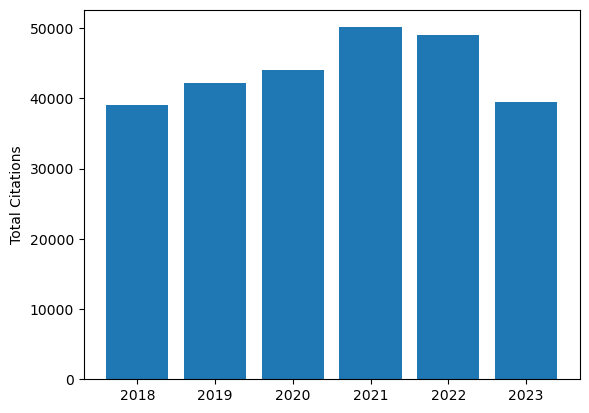

In [73]:
# Create citations per year dataframe
cites_df = pd.DataFrame(cites_per_year)

# Add a totals column
cites_df.loc['Total']= cites_df.sum()

# Select years to plot
cites_df_selected = cites_df[[2018,2019,2020,2021,2022,2023]]

# Select the last row (totals) 
cites_df_total = cites_df_selected.iloc[-1:]

# Create barplot
years = list(cites_df_total.columns)
cites = cites_df_total.values.tolist()[0]
plt.bar(years, cites )
plt.ylabel('Total Citations')

# !!! Modify this - name the output PDF file
# plt.savefig(bargraph_output)
plt.savefig("gs_SMS_graph_nodupes.pdf")

9. Create collaboration heatmap

['Tim H. Murphy', 'Andy Shih', 'Lynn Raymond', 'Craig E. Brown', 'Jeffrey LeDue', 'Terry Snutch', 'Yu Tian Wang', 'Brian MacVicar', 'Wolfram Tetzlaff', 'Helge Rhodin', 'Peter Cripton', 'Mark Cembrowski', 'Annie Ciernia', 'Anthony Phillips', 'Shernaz Bamji', 'Silke Cresswell', 'Leigh Anne Swayne', 'Fabio Rossi', 'Ian Mackenzie', 'Fidel Vila-Rodriguez', 'Z. Jane Wang', 'Sophia Frangou', 'Jason Snyder', 'Todd Woodward', 'Paul Pavlidis', 'Kurt Haas', 'Catharine Rankin', 'Lara Boyd', 'Martin McKeown', 'A Jon Stoessl', 'Vesna Sossi', 'Liisa Galea', 'Brian D. Fisher', 'Peyman Servati', 'Catharine Winstanley', 'Jane Roskams', 'Jeremy Seamans', 'Leonid Sigal', 'Eric Shea-Brown', 'Randy Mcintosh', 'Adrienne Fairhall', 'Ilker Hacihaliloglu', 'Purang Abolmaesumi']


/var/folders/47/6bm96nxd0ks5x370bsvkpghh0000gn/T/ipykernel_6894/2621153511.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = CM.get_cmap('nipy_spectral')


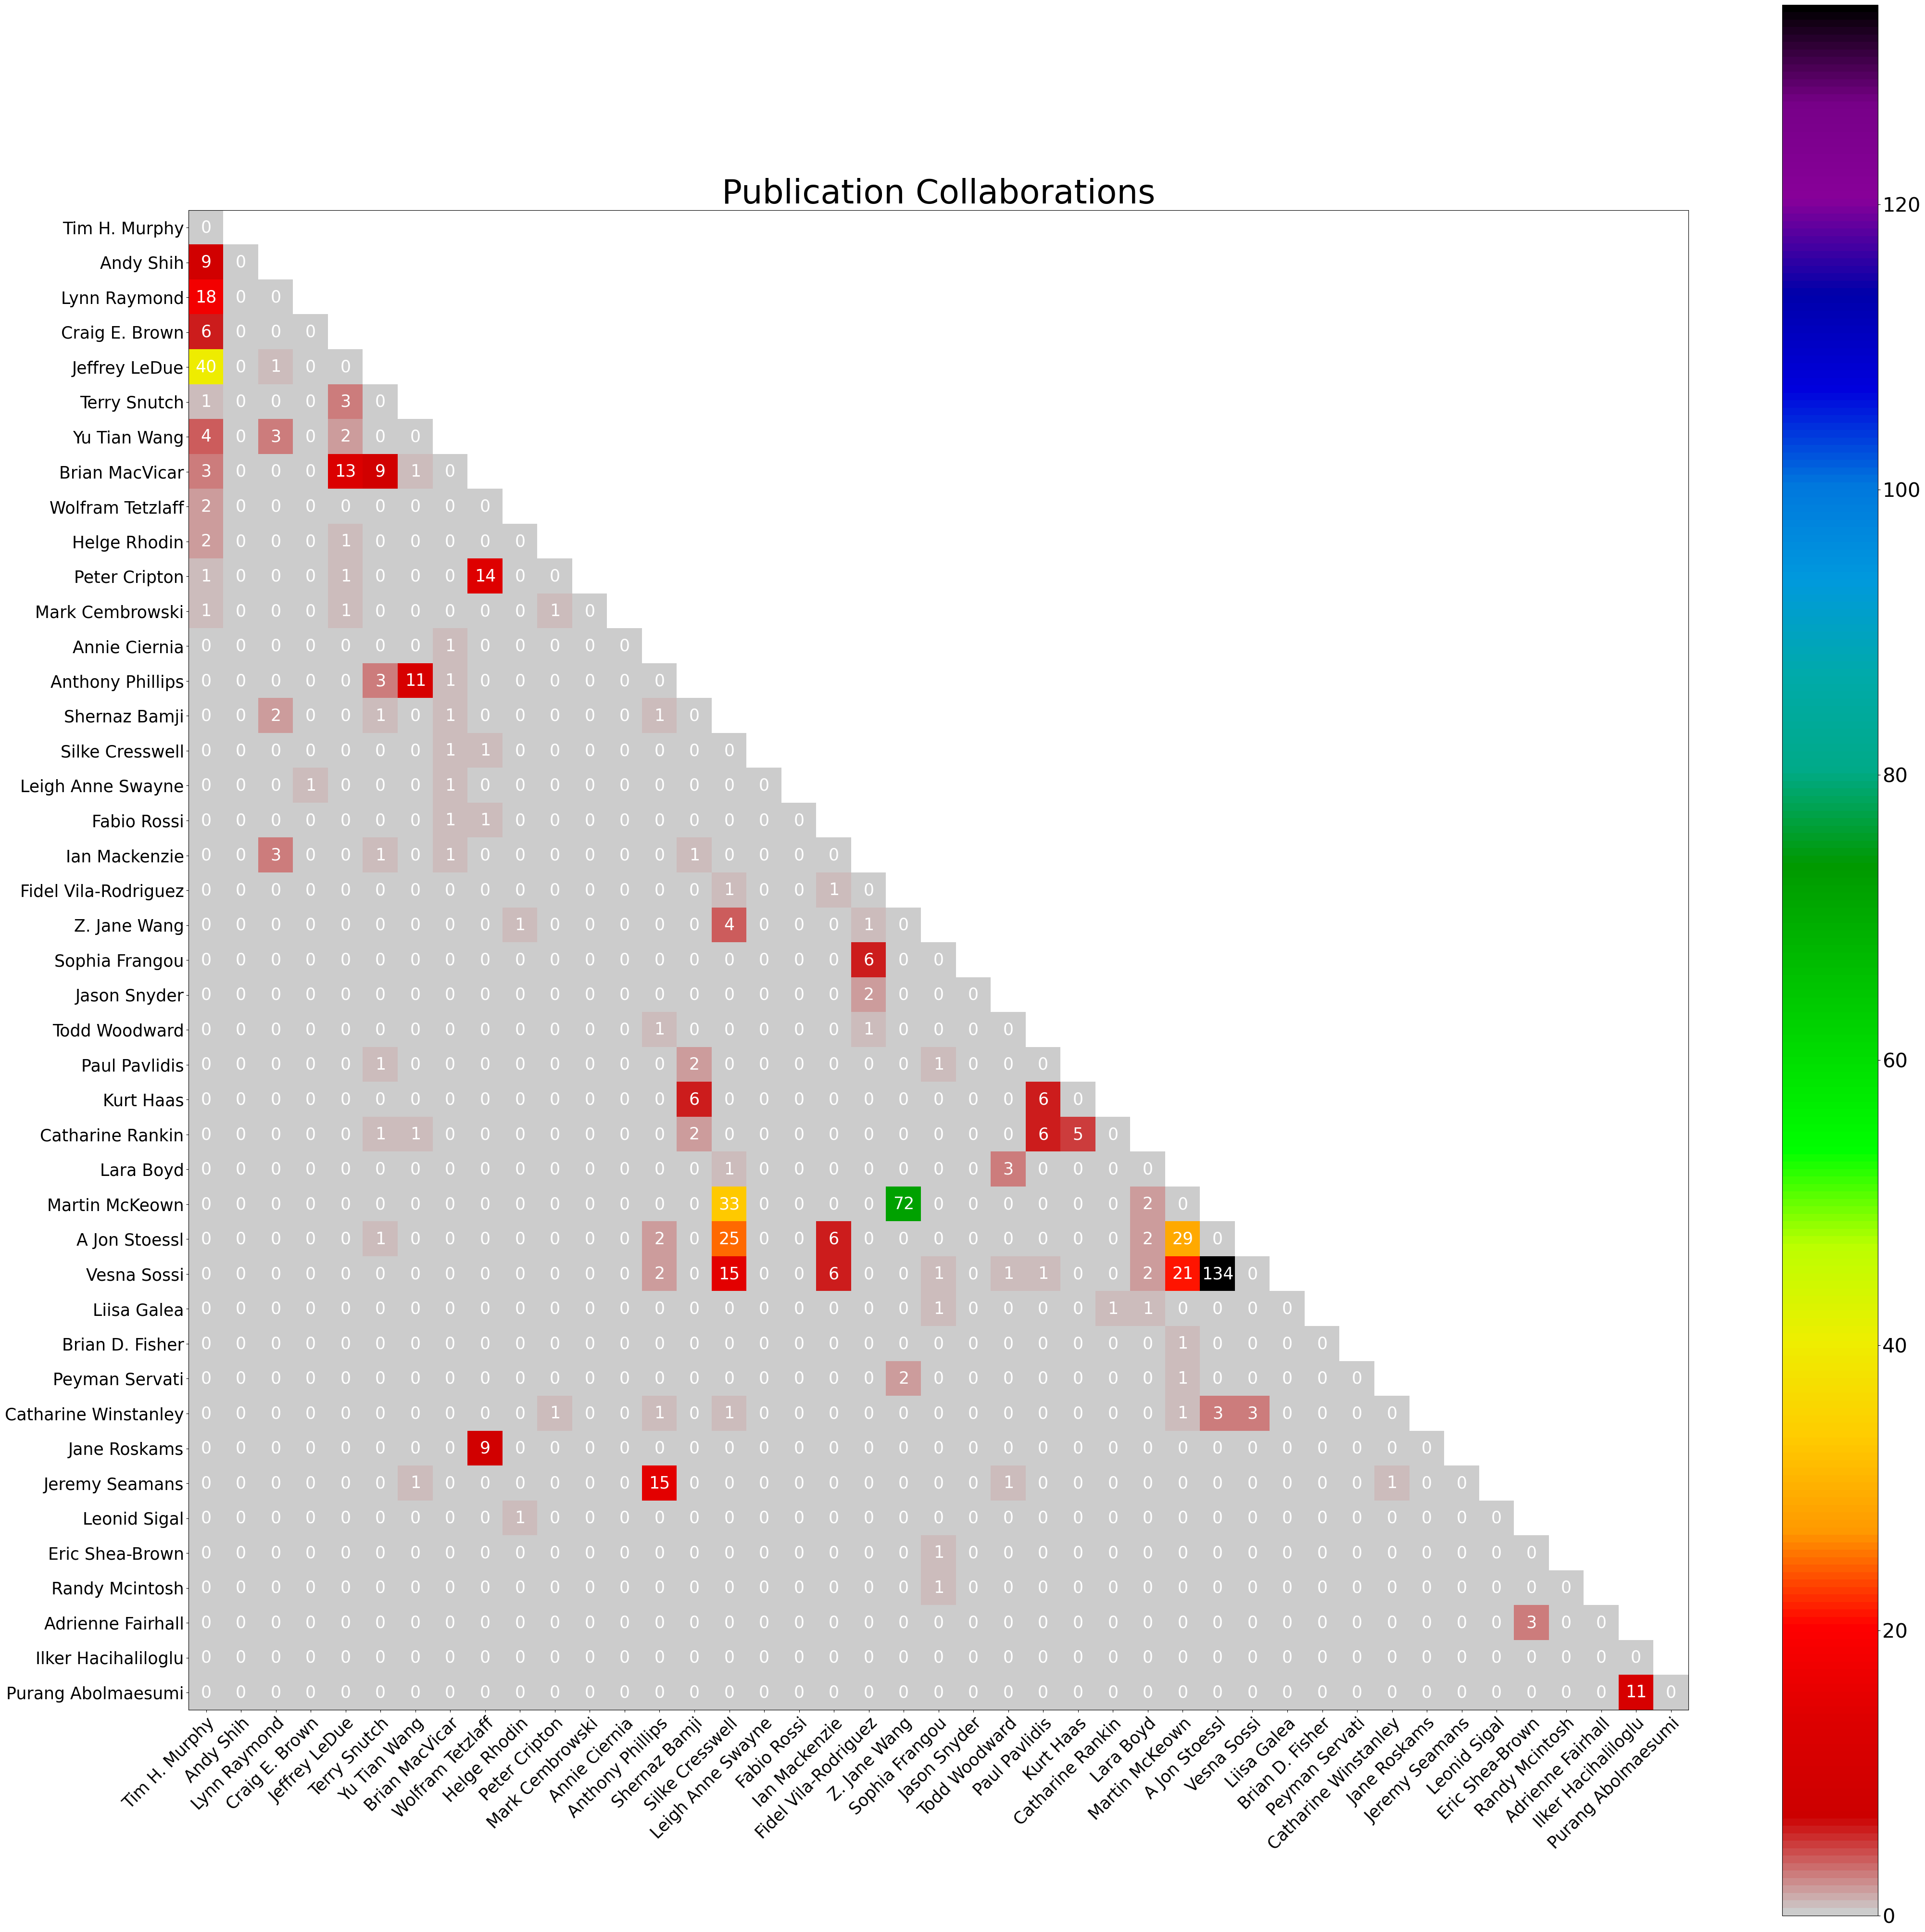

In [74]:
authors = list(collabs_dict.keys())
print(authors)
author_count=len(authors)
# Initialize array with zeros. 
collabs_array = np.zeros((author_count, author_count), dtype=int)

# Populate the array with the number of collaborations between authors
for i, athr in enumerate(authors):
    for j, name in enumerate(authors):
        if name in collabs_dict[athr].keys():
            collabs_array[i][j] = collabs_dict[athr][name]
            
# Only display the lower triangle of the matrix
mask =  np.tri(collabs_array.shape[0], k=-1)
collabs_array = np.ma.array(collabs_array, mask=mask).T

# Set up the colourmap 
cmap = CM.get_cmap('nipy_spectral') 
cmap = cmap.reversed()

### Create heatmap ###

fig = plt.figure(figsize = (author_count,author_count)) 
ax = fig.add_subplot(111)
im = ax.imshow(collabs_array, cmap=cmap, interpolation='nearest', 
               #norm=matplotlib.colors.LogNorm()            # Uncomment this if you want a logarithmic colormap
              )

# Show the ticks
ax.set_xticks(np.arange(author_count))
ax.set_yticks(np.arange(author_count))

# Label the ticks with author names - you can modify the authorname font size here
ax.set_xticklabels(authors,fontsize=25)
ax.set_yticklabels(authors, fontsize=25)

# Rotate and align tick labels.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Create numeric annotations.
for i in range(author_count):
    for j in range(author_count):
        text = ax.text(j, i, collabs_array[i, j],
                       ha="center", va="center", color="w", fontsize=25)
# Fit plot within figure        
fig.tight_layout()


# Add title - you can change the title and title font size here
ax.set_title("Publication Collaborations", fontsize = 50)

# Add the colorbar and add ticks - change colorbar label fontsize here
cbar = fig.colorbar(im)
cbar.ax.tick_params(labelsize=30)

# Save the figure as PDF - you can modify the filename here. 
# plt.savefig(figure_output)
plt.savefig("gs_SMS_heatmap_nodupes.pdf")

plt.show()


10.  Investigate Co-Authorship Network

In [28]:
#create network diagram
import networkx as nx
import bct

In [33]:
for i, athr in enumerate(authors):
    for j, name in enumerate(authors):
        if name in collabs_dict[athr].keys():
            collabs_array[i][j] = collabs_dict[athr][name]

In [34]:
inversed_gs_matrix = 1/collabs_array[collabs_array > 0]
collabs_array[collabs_array > 0] = inversed_gs_matrix

print(inversed_gs_matrix)

gs_weighted_centrality = bct.betweenness_wei(inversed_gs_matrix)

gs_weighted_centrality_normed = gs_weighted_centrality*2/((len(gs_weighted_centrality)-1)*(len(gs_weighted_centrality)-2))

[0.1111111111111111 0.05555555555555555 0.16666666666666666 0.025 1.0 0.25
 0.3333333333333333 0.5 0.5 1.0 1.0 0.1111111111111111 0.05555555555555555
 0.5 0.3333333333333333 0.5 0.3333333333333333 0.16666666666666666 1.0
 0.025 0.5 0.3333333333333333 0.5 0.07692307692307693 1.0 1.0 1.0 1.0
 0.3333333333333333 0.1111111111111111 0.3333333333333333 1.0 1.0 1.0 1.0
 1.0 0.25 0.3333333333333333 0.5 1.0 0.09090909090909091 1.0 1.0
 0.3333333333333333 0.07692307692307693 0.1111111111111111 1.0 1.0 1.0 1.0
 1.0 1.0 1.0 1.0 0.5 0.07142857142857142 1.0 1.0 0.1111111111111111 0.5
 1.0 1.0 1.0 1.0 1.0 0.07142857142857142 1.0 1.0 1.0 1.0 1.0 1.0
 0.3333333333333333 0.09090909090909091 1.0 1.0 1.0 0.5 0.5 1.0
 0.06666666666666667 0.5 1.0 1.0 1.0 1.0 0.5 0.16666666666666666 0.5 1.0
 1.0 1.0 0.25 1.0 0.030303030303030304 0.04 0.06666666666666667 1.0 1.0
 1.0 1.0 1.0 0.3333333333333333 1.0 1.0 1.0 1.0 0.16666666666666666
 0.16666666666666666 1.0 1.0 1.0 0.16666666666666666 0.5 1.0 1.0 0.25 1.0
 0.0138

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
print(gs_weighted_centrality_normed)

In [27]:
coauthor_network = nx.Graph()
coauthor_network.add_nodes_from(author)
inv_weight = True

for author, coauthors in collabs_dict.items():
    if len(coauthors) == 0: print(author, "has no coauthors")
    #add the nodes
    for coauthor in coauthors.keys():
        if inv_weight:
            coauthor_network.add_edge(author, coauthor, weight=int((1/coauthors[coauthor])*100)) #invert and convert to int to prevent floating number errors as suggested
        else:
            coauthor_network.add_edge(author, coauthor, weight=coauthors[coauthor]) 



[('Tim H. Murphy', 'Andy Y. Shih'), ('Tim H. Murphy', 'Lynn A Raymond'), ('Tim H. Murphy', 'Craig E. Brown'), ('Tim H. Murphy', 'Jeffrey LeDue'), ('Tim H. Murphy', 'Snutch'), ('Tim H. Murphy', 'Yu Tian Wang'), ('Tim H. Murphy', 'Brian MacVicar'), ('Tim H. Murphy', 'Wolfram Tetzlaff'), ('Tim H. Murphy', 'Helge Rhodin'), ('Tim H. Murphy', 'Peter Cripton'), ('Tim H. Murphy', 'Mark S. Cembrowski'), ('Lynn A Raymond', 'Shernaz Bamji'), ('Lynn A Raymond', 'Ian Mackenzie'), ('Lynn A Raymond', 'Yu Tian Wang'), ('Lynn A Raymond', 'Jeffrey LeDue'), ('Craig E. Brown', 'Leigh Anne Swayne'), ('Jeffrey LeDue', 'Brian MacVicar'), ('Jeffrey LeDue', 'Yu Tian Wang'), ('Jeffrey LeDue', 'Helge Rhodin'), ('Jeffrey LeDue', 'Peter Cripton'), ('Jeffrey LeDue', 'Mark S. Cembrowski'), ('Jeffrey LeDue', 'Snutch'), ('Snutch', 'Brian MacVicar'), ('Snutch', 'Ian Mackenzie'), ('Snutch', 'Shernaz Bamji'), ('Snutch', 'Paul Pavlidis'), ('Snutch', 'A Jon Stoessl OR jon Stoessl'), ('Snutch', 'Anthony Phillips'), ('Snutch

In [35]:
gs_degrees_networkX = [len([n for n in coauthor_network.neighbors(node)]) for node in coauthor_network.nodes]

In [36]:
print(gs_degrees_networkX)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 1, 5, 2, 8, 9, 7, 11, 5, 4, 5, 3, 8, 7, 2, 6, 8, 9, 6, 4, 1, 9, 2, 1, 1, 5, 7, 10, 5, 3, 6, 6, 8, 6, 1, 2, 3, 2, 1, 1, 1, 1, 1]


In [ ]:
gs_g = get_networkx_matrix(nx.Graph(),combined_df,'gs_name','gs_coauthors', inv_weight=True)